In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Voting History Table

In [75]:
vdf = pd.read_csv('/Users/willmayer/Desktop/DS3001/project/DS3001-Final-Project/data/voting_VA.csv', low_memory=False) # Voting history by county
vdf = vdf[vdf['year'] != 2000]
vdf = vdf[vdf['year'] != 2004]

path = '/Users/willmayer/Desktop/DS3001/DS3001-Final-Project/data/county_data/utf8_justVA' # County demographics
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
dfs = {}
for file in csv_files:
    file_path = os.path.join(path, file)
    dfs[file] = pd.read_csv(file_path) # Dictionary of demographic tables

2020 was split into three observations/candidate b/c of alternative voting methods--this block cleans every 3 rows to a 'total' column

In [76]:
df2020 = vdf.loc[vdf['year']==2020,:] 
df2020 = df2020.reset_index(drop=True) 
df2020['group'] = df2020.index // 3     # Create a group identifier every 3 rows

# Dynamically create an aggregation dictionary
# Use 'first' for all columns except 'candidatevotes', which should be summed
agg_dict = {col: 'first' for col in df2020.columns if col != 'candidatevotes'}
agg_dict['candidatevotes'] = 'sum'  # Summing only the 'candidatevotes' column

df_collapsed = df2020.groupby('group').agg(agg_dict).reset_index(drop=True)

df_collapsed = df_collapsed.drop(columns=['group'], errors='ignore')

In [77]:
vdf_filtered = vdf[vdf['year'] != 2020] # Put fixed 2020 back together
vdf = pd.concat([vdf_filtered, df_collapsed], ignore_index=True)
vdf['mode'] = 'TOTAL' # All the counts are totals now

From the voting dataframe, make a tidy dataset where each observation is a (year, county) pair. We can eventually add demographic information.

In [78]:
df_dem = vdf[vdf['party']=='DEMOCRAT'] # Make 'dvotes' 'rvotes' and 'ivotes' columns
df_rep = vdf[vdf['party']=='REPUBLICAN']
df_other = vdf[vdf['party']=='OTHER']
df_dem_sum = df_dem.groupby(['county_fips', 'year'])['candidatevotes'].sum().reset_index(name='dvotes')
df_rep_sum = df_rep.groupby(['county_fips', 'year'])['candidatevotes'].sum().reset_index(name='rvotes')
df_other_sum = df_other.groupby(['county_fips', 'year'])['candidatevotes'].sum().reset_index(name='ivotes')
df_votes = pd.merge(df_dem_sum, df_rep_sum, on=['county_fips', 'year'], how='outer')
df_votes = pd.merge(df_votes, df_other_sum, on=['county_fips','year'],how='outer')

Calculate the winner and margin for each year-county pair

In [79]:
def winner(row):
    votes = {'d': row['dvotes'], 'r': row['rvotes'], 'i': row['ivotes']}
    return max(votes, key=votes.get)  # Return the key with the highest value
def margin(row):
    votes = sorted([row['dvotes'], row['rvotes'], row['ivotes']], reverse=True)
    return votes[0] - votes[1]  # Margin is the difference between highest and second-highest
def sumvotes(row):
    return row['rvotes'] + row['dvotes'] + row['ivotes'] # Total votes for observation

In [80]:
df_votes['winner'] = df_votes.apply(winner, axis=1) # Make 'winner,' 'margin,' and 'total_votes' columns
df_votes['margin'] = df_votes.apply(margin, axis=1)
df_votes['total_votes'] = df_votes.apply(sumvotes, axis=1)

This makes a column 'rdummy' coded as follows (x = 1 if winner was Republican, 0 otherwise) for linear regression

In [81]:
def rdummy(row):
    return 1 if row['winner'] == 'r' else 0

In [82]:
df_votes['rdummy'] = df_votes.apply(rdummy, axis=1)

In [83]:
df_votes = df_votes.reset_index(drop=False) # Create an index to make matching easy

## Merge demographic information with vote information

Each observation is a year-county pair with a bunch of demographic columns

The demographic years are in intervals so we have to match them to election years

In [84]:
dfs['0002_ds206_20145_county_E.csv']['YEAR'] = 2012
dfs['0002_ds239_20185_county_E.csv']['YEAR'] = 2016
dfs['0002_ds249_20205_county_E.csv']['YEAR'] = 2020
dfs['0002_ds176_20105_county_E.csv']['YEAR'] = 2008

In [85]:
stacked_r = pd.concat(dfs.values(),ignore_index=True) # Put the 5 demographic tables together (stacked)
stacked_r.rename(columns={'YEAR':'year','COUNTYA':'county_fips'}, inplace=True)
df_votes['county_fips'] = df_votes['county_fips'] - 51000
df_votes = pd.merge(df_votes, stacked_r, on=['county_fips', 'year'], how='left') # Match voting history with demographics

### Melt Demographics Variables

Each demographic table (year) has a different column name for a given variable, so we'll have to identify each variable we want to use and put it in the melter. For now, we'll start with median household income, total population, and % white population in each county.

In [86]:
def melter(df, map, index, name):
    x = df.rename(columns=map).melt(id_vars=[index], value_vars=map.values(), value_name=name)
    x = x.drop(columns=['variable']).dropna()
    return pd.merge(df, x[[index, name]], on=index, how='left')

In [87]:
df = df_votes
income_map = {
    'JOHE001':'Income1',
    'QU0E001':'Income2',
    'ABDOE001':'Income3',
    'AJY9E001':'Income4',
    'AMR7E001':'Income5',
}

white_map = {
    'JMBE002':'White1',
    'QSQE002':'White2',
    'ABA2E002':'White3',
    'AJWNE002':'White4',
    'AMPWE002':'White5'
}

pop_map = {
    'JMAE001':'pop1',
    'QSPE001':'pop2',
    'ABA1E001':'pop3',
    'AJWME001':'pop4',
    'AMPVE001':'pop5'
}

rent_map = {
    'JS5E001':'rent1',
    'ABIHE001':'rent2',
    'AJ3EE001':'rent3',
    'QZTE001':'rent4',
    'AMVZE001':'rent5'
}

poverty_map = {
    'JOCE001' : 'p1',
    'ABDJE001': 'p2',
    'AJY4E001': 'p3',
    'AMZME001': 'p4',
    # 'AMZMM001': 'p5'
}

maps = {
    'income': income_map,
    'totpop': pop_map,
    'whitepop': white_map,
    'median_rent': rent_map,
    'poverty_ratio': poverty_map
}

index = 'index'

for name, map in maps.items():
    df = melter(df, map, index, name)

Calculate percent white for graphing purposes

In [88]:
df['pctwhite'] = (df['whitepop'] / df['totpop']) * 100

Reorder columns--clean dataseet! We can update this to include more variables as we find them in the codebook.

In [89]:
df = df.loc[:, ~df.columns.duplicated()]

The demographic years are in intervals so we have to match them to election years

In [90]:
dfs['0002_ds206_20145_county_E.csv']['YEAR'] = 2012
dfs['0002_ds239_20185_county_E.csv']['YEAR'] = 2016
dfs['0002_ds249_20205_county_E.csv']['YEAR'] = 2020
dfs['0002_ds176_20105_county_E.csv']['YEAR'] = 2008

In [91]:
order = ['county_fips', 'year', 'winner', 'margin', 'dvotes', 'rvotes', 'ivotes', 'total_votes', 'COUNTY', 'rdummy', 'income', 
         'poverty_ratio', 'median_rent','totpop', 'whitepop','pctwhite', 'total_votes']
others = [x for x in df_votes.columns if x not in order]
df = df.loc[:, order + others]

In [92]:
df = df.loc[:, ~df.columns.duplicated()]

## Plots

Text(0.5, 1.0, 'Democrats win counties by larger margins')

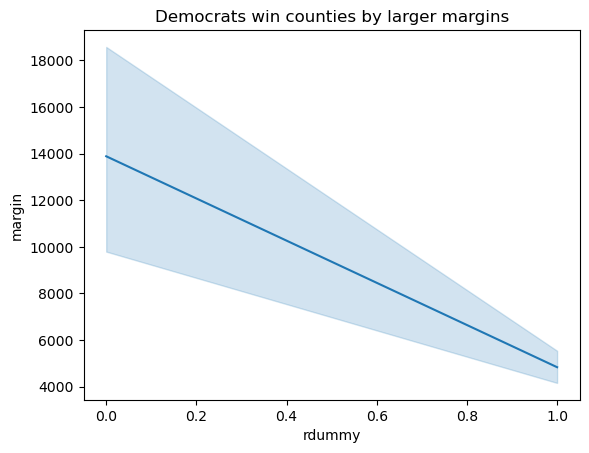

In [93]:
sns.lineplot(df, x='rdummy', y='margin')
plt.title('Democrats win counties by larger margins')

Text(0.5, 1.0, 'Median annual household income by county. X=1 means county voted Republican')

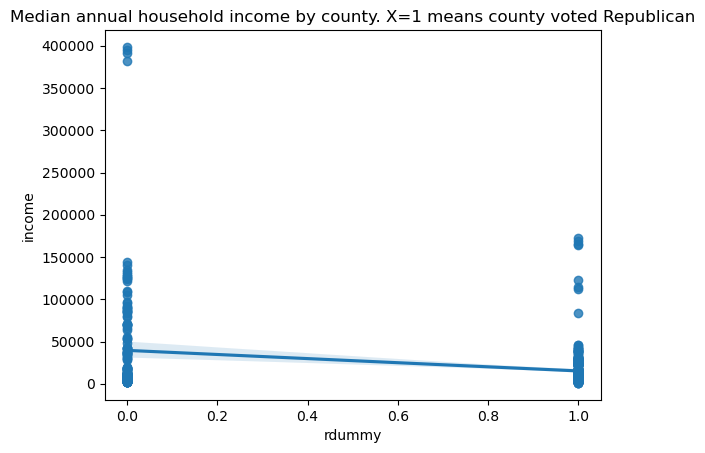

In [94]:
sns.regplot(data=df, x='rdummy', y='income')
plt.title('Median annual household income by county. X=1 means county voted Republican')

Text(0.5, 1.0, '% White Population in County. X=1 means county voted Republican.')

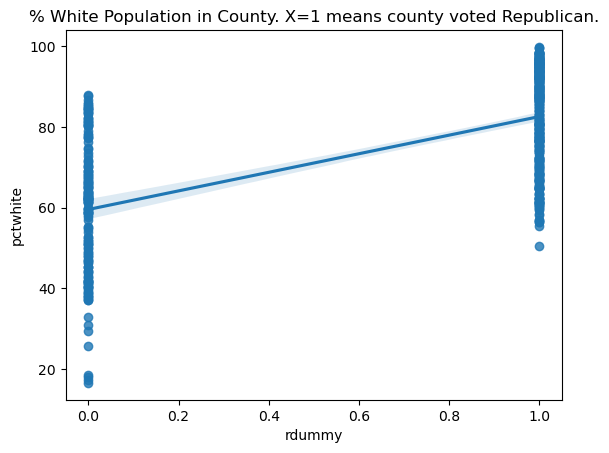

In [95]:
sns.regplot(df, x='rdummy', y='pctwhite')
plt.title("% White Population in County. X=1 means county voted Republican.")

Text(0.5, 1.0, 'Margin of Victory Over Time')

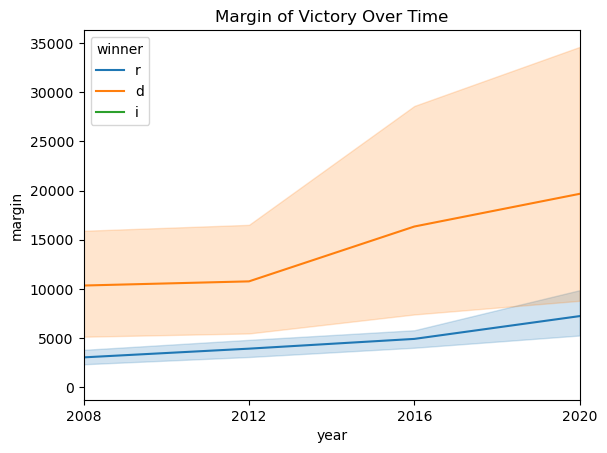

In [96]:
sns.lineplot(df, x='year', y='margin', hue='winner') # Interesting choice of hues
xticks = [2008, 2012, 2016, 2020]
plt.xticks(xticks)
plt.xlim(2008, 2020)
plt.title('Margin of Victory Over Time')

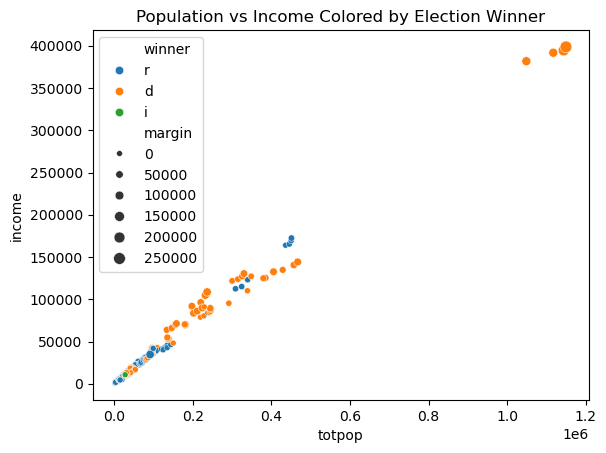

In [97]:
sns.scatterplot(df, x='totpop', y='income', hue='winner', size='margin') # See fairfax VA in the top right
plt.title('Population vs Income Colored by Election Winner')
plt.show()

Text(0.5, 1.0, 'Voter turnout increases over year')

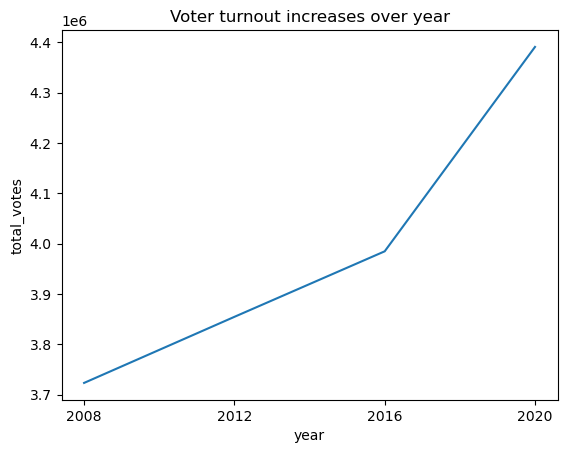

In [98]:
yearly = df.groupby('year')['total_votes'].sum()
yearly = df.groupby('year', as_index=False)['total_votes'].sum()

sns.lineplot(data=yearly, x='year', y='total_votes')
plt.xticks(xticks)
plt.title('Voter turnout increases over year')

PCA? I don't think we need to do this...

In [108]:
variables = ['total_votes', 'income', 'poverty_ratio', 'median_rent', 'totpop', 'whitepop']
X = df.loc[:, variables]

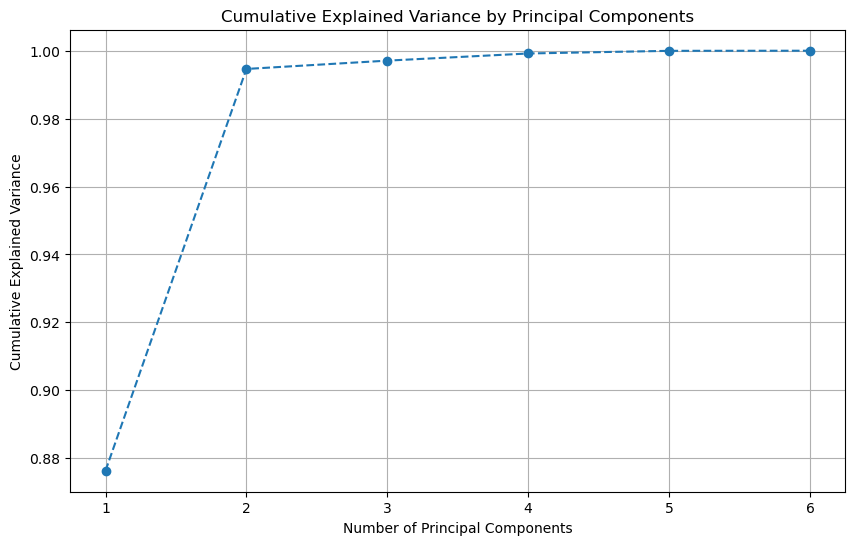

In [109]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = X.dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

pca = PCA()
pca_result = pca.fit_transform(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [110]:
pca = PCA(n_components = 2)
pca = pca.fit(X)
Z = pca.transform(X)

In [111]:
loadings = pd.DataFrame(
    pca.components_,
    columns=X.columns,
)
loadings

,total_votes,income,poverty_ratio,median_rent,totpop,whitepop
0,0.292537,0.215224,0.5991,0.000761,0.606996,0.375147
1,0.017048,-0.097061,-0.2359,0.000175,-0.307450,0.916577


use either logistic regression or random forests, don't use pcs